# Class-agnostic semantic edges with U-net and weighted Binary Cross Entropy Loss

# Personal Info
Name: Nicholas Jiang

UW Email: n45jiang@uwaterloo.ca

# Abstract

The goal of this project is to train a model to classify edges using an estimated ground truth for edges generated from the PASCAL VOC dataset. These edges correspond to "semantic edges", which are pixels between two differently labeled regions in the dataset. Such edges are typically labeled as "void" in the PASCAL VOC dataset and represent important boundaries for semantic segmentation tasks. The completed model will be a binary classifier that will label pixels in an input image as either edge (postive) or non-edge (negative).

The difficulty with training the model here is that the data is imbalanced. In the generated edge map, edge (positive) classifications will account for less than 5% of the total data. To address this, a weighted binary cross entropy (BCE) loss is used. For the base model, I use U-Net, which is well-suited for segmentation tasks due to its ability to combine spatial data through skip connections with feature extraction via the encoder-decoder structure. This approach aims to produce a model capable of effectively identifying semantic edges despite the imbalance in the training data.

# Code Libraries



**matplotlib**: Used for plotting.

**torch**: Defines and trains the U-Net model; imports BCEWithLogitsLoss for handling imbalanced data; preparing the edge mask dataset.

**torchvision**: Provides the PASCAL VOC dataset and is used for downloading it.

**tqdm**: Creates progress bars for better user experience.

**ipywidgets, pandas**: Not explicitly used but necessary as dependencies for other libraries (e.g., Jupyter and seaborn).

**torchmetrics**: Provides an implementation of MIoU for evaluation

This notebook will run as-is on Google Colab (without any other installation). You can do pip install _ for all of the code libraries if you want to run it locally.

# Conceptual Section

Illustrating the problem of imbalanced data for BCE loss in binary classification and how using a weight on the minority class solves the issue.

Here, I will show how the problem of imbalanced data affects our results for binary class prediction.

We have the Binary Cross Entropy (BCE) loss below:

$$Loss=-\frac{1}{N}\sum_{i=1}^Ny_{i}\log(p(y_{i}))+(1-y_{i})\log(1-p(y_{i}))$$

For the sake of argument, let $p(y_i)=\alpha$ be a constant function

Also, assume that we have N-1 negative examples and 1 positive example. let's apply this information to the above loss function.

$$\begin{align*}
Loss  & =-\frac{1}{N}\left(\log(\alpha)+(N-1)\log(1-\alpha)\right) \\
 & = -\frac{1}{N}\log(\alpha)-\frac{N-1}{N}\log(1-\alpha) \\
 & = -\frac{1}{N}\log(\alpha)+\left( \frac{1}{N}-1 \right)\log(1-\alpha)  \\
\implies \lim_{ N \to \infty } Loss & =-\log(1-\alpha)
\end{align*}$$

The model can pick arbitrarily small $\alpha$ with $\alpha>0$ to achieve a low loss. This makes sense since we have so many negative examples and only one positive example. However, what if we care about not mislabelling positive examples? We will need to change something.

Let's introduce $$w=\frac{\text{number of negative examples}}{\text{number of positive examples}}$$
so that $$w=\frac{N-1}{1}=N-1$$
in this example.

We add w as a weight to the positive part of the loss as below:
$$\begin{align*}
Loss & =-\frac{1}{N}\sum_{i=1}^{N} w \cdot y_{i}\log(p(y_{i}))+(1-y_{i})\log(1-p(y_{i})) \\
 & =-\frac{N-1}{N}\log(\alpha)-\frac{N-1}{N}\log(1-\alpha) \\
 & =\left( \frac{1}{N}-1 \right)\log(\alpha)+\left( \frac{1}{N}-1 \right)\log(1-\alpha) \\
\end{align*}$$
Then
$$\lim_{ N \to \infty } Loss=-\log(\alpha)-\log(1-\alpha)$$
If we take the same "strategy" and set a very small $\alpha$ s.t. $\alpha>0$  then $-\log(1-\alpha)\approx0$ but $-\log(\alpha)$ then becomes very large. The old strategy no longer works to get a low loss when we have weighted the positive part of the BCE loss. We have effectively "penalized" the model for ignoring the positive class using the weight.

Now, I will demonstrate this in practice

# Preparing the edge dataset

Below, I will prepare a dataset with input images and their estimated ground truth edge mask from the PASCAL VOC dataset.

Download the PASCAL VOC dataset

In [1]:
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np
import torch

On inspection of the pascal VOC data. We see that the label void (255) looks to be representative of edges. We will use this property in the creation of an estimated ground truth for edges. Here, we will map 255 to 1 for edges and other colors to 0.

In [2]:
# Define dataset root
data_dir = './data'

# Initialize the VOCSegmentation dataset
voc_full = VOCSegmentation(
    root=data_dir,
    year='2012',
    image_set='trainval',
    download=True
)

100%|██████████| 2.00G/2.00G [01:31<00:00, 21.9MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


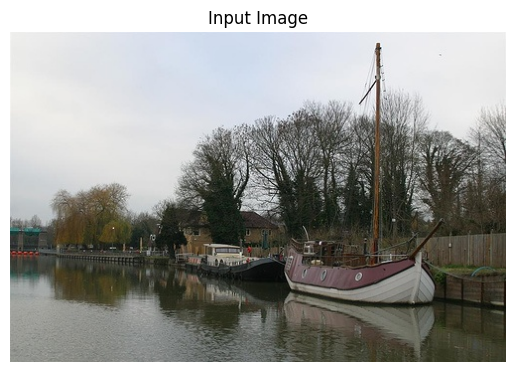

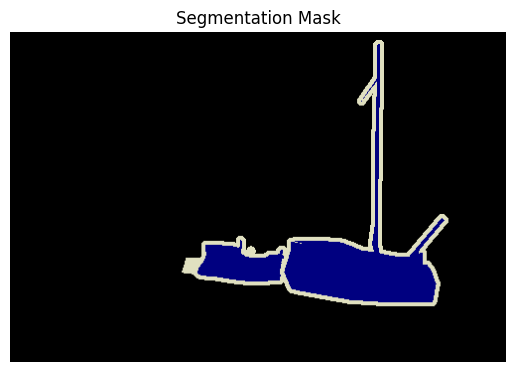

In [3]:
boat = voc_full[4]


# Display the image
plt.imshow(boat[0])
plt.title("Input Image")
plt.axis('off')
plt.show()

# Display the segmentation mask
plt.imshow(boat[1])
plt.title("Segmentation Mask")
plt.axis('off')
plt.show()

Now we try to get an edge map for this boat example. We convert the segmentation mask into a binary edge mask.

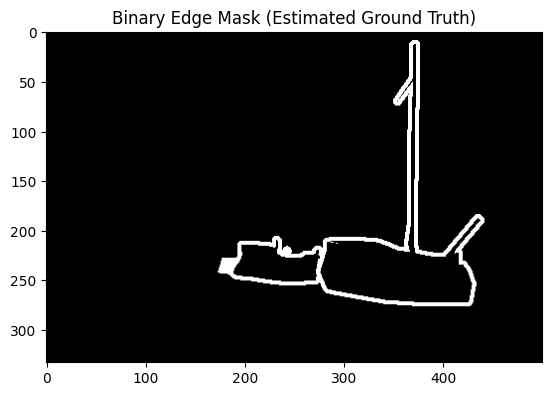

In [4]:
boat_mask = boat[1]

# For demonstration purposes only. I use pytorch transforms in the actual code later.
def get_edge_mask(segmentation_mask):
    """
    Converts a PASCAL VOC segmentation mask into a binary edge mask.
    Parameters:
        segmentation_mask: A PIL image object representing the segmentation mask
    Returns:
        A numpy array where the edges are marked as 1 and everything else is 0
    """
    # Convert PIL image to numpy array
    segmentation_mask_arr = np.asarray(segmentation_mask)
    # Generate edge mask
    edge_mask = (segmentation_mask_arr == 255).astype(np.uint8)
    return edge_mask


edge_mask = get_edge_mask(boat_mask)
plt.title("Binary Edge Mask (Estimated Ground Truth)")
plt.imshow(edge_mask, cmap='gray')

Create a custom 70/10/20 split between training, valuation, and test data for use with the model later.

In [5]:
from torch.utils.data import Subset

# Define split sizes
train_size = 0.7
val_size = 0.1
test_size = 0.2

indices = list(range(len(voc_full)))

# Calculate the number of samples for each set
train_count = int(train_size * len(voc_full))
val_count = int(val_size * len(voc_full))
test_count = len(voc_full) - train_count - val_count

train_indices = indices[:train_count]
val_indices = indices[train_count:train_count+val_count]
test_indices = indices[train_count+val_count:]

train_subset = Subset(voc_full, train_indices)
val_subset = Subset(voc_full, val_indices)
test_subset = Subset(voc_full, test_indices)

In [6]:
# Print dataset sizes
print(f"Train dataset size: {len(train_subset)}")
print(f"Validation dataset size: {len(val_subset)}")
print(f"Test dataset size: {len(test_subset)}")

Train dataset size: 2039
Validation dataset size: 291
Test dataset size: 583


Wrap the voc data along with the edge masks in a dataset

Here, ToTensor() is used to convert input images and masks into PyTorch tensors. Tensors are the fundamental data structure in PyTorch and allows efficient operations on multi-dimensional arrays, including matrix manipulations and GPU acceleration.

For the images, this conversion also scales pixel values from the typical range [0, 255] to [0, 1], which is essential for deep learning models to perform numerical computations effectively.

When the segmentation mask is converted to a tensor, the label 255 for 'void' is scaled to 1. We create an edge mask to determine whether a pixel in the segmentation mask counts as an edge.

In [7]:
import torchvision.transforms as transforms

image_transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x == 1).float()) # Get edge mask
])

In [8]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms.functional as TF

class VOCWithEdgeMask(Dataset):
    def __init__(self, dataset, image_transform=None, mask_transform=None):
        self.dataset = dataset
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label_mask = self.dataset[idx]

        # Apply transforms
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            edge_mask = self.mask_transform(label_mask)

        return img, edge_mask


train_dataset_edge_mask = VOCWithEdgeMask(
    dataset=train_subset,
    image_transform=image_transform,
    mask_transform=mask_transform
)

val_dataset_edge_mask = VOCWithEdgeMask(
    dataset=val_subset,
    image_transform=image_transform,
    mask_transform=mask_transform
)

test_dataset_edge_mask = VOCWithEdgeMask(
    dataset=test_subset,
    image_transform=image_transform,
    mask_transform=mask_transform
)

## Initialize Dataloaders for training the network.

Dataloaders are used to efficiently handle data during training. They manage tasks like batching, shuffling, and parallel data loading. Dataloaders enable Stochastic Gradient Descent (SGD) by providing random, manageable chunks of data for each iteration, ensuring efficient memory usage and diverse input samples.

The U-net model expects the batches of training samples to be of the same dimensions. We can achieve this by padding. However, running training on padded areas wastes resources so we dynamically pad to the largest dimensions in the batch rather than over the entire dataset.

Dynamic padding per batch implementation

In [9]:
def dynamic_pad_collate(batch):
    # Determine max height and width in this batch
    heights = [item[0].shape[1] for item in batch]
    widths = [item[0].shape[2] for item in batch]
    max_height = max(heights)
    max_width = max(widths)

    # Round up to nearest multiple
    def round_up(x, multiple=16):
        return ((x - 1) // multiple + 1) * multiple

    max_height = round_up(max_height)
    max_width = round_up(max_width)

    padded_imgs = []
    padded_masks = []
    for img, mask in batch:
        pad_width = max_width - img.shape[2]
        pad_height = max_height - img.shape[1]

        img_padded = torch.nn.functional.pad(img, (0, pad_width, 0, pad_height))
        mask_padded = torch.nn.functional.pad(mask, (0, pad_width, 0, pad_height))

        padded_imgs.append(img_padded)
        padded_masks.append(mask_padded)

    imgs_tensor = torch.stack(padded_imgs)
    masks_tensor = torch.stack(padded_masks)
    return imgs_tensor, masks_tensor

In [10]:
import os
num_workers = os.cpu_count()
batch_size = 8

train_loader = DataLoader(train_dataset_edge_mask, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=dynamic_pad_collate)
val_loader = DataLoader(val_dataset_edge_mask, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=dynamic_pad_collate)
test_loader = DataLoader(test_dataset_edge_mask, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=dynamic_pad_collate)

Let's check to see that our dynamic padding worked.

In [17]:
i = 1
for img, mask in train_loader:
    print(img.shape)
    print(mask.shape)
    print(torch.unique(mask))  # Should be 0 and 1
    print("---")
    if i == 5:
        break
    i += 1

torch.Size([8, 3, 384, 512])
torch.Size([8, 1, 384, 512])
tensor([0., 1.])
---
torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])
tensor([0., 1.])
---
torch.Size([8, 3, 400, 512])
torch.Size([8, 1, 400, 512])
tensor([0., 1.])
---
torch.Size([8, 3, 400, 512])
torch.Size([8, 1, 400, 512])
tensor([0., 1.])
---
torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])
tensor([0., 1.])
---


In the output, we see that not all batches are padded to the maximum dimensions of 512x512. Instead, the dimensions vary based on the largest sample in each batch (e.g., some batches are 400x512).

# UNet Definition

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, num_classes=1):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)     # Out: 64 channels
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)   # Out: 128 channels
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # ...
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1) # Out: 1024 channels

        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        # Each "up" step consists of a transposed convolution to upsample, followed by a convolution
        # After upsampling, we concatenate with the corresponding encoder feature map.

        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.dec1 = nn.Conv2d(1024, 512, 3, padding=1)

        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.dec2 = nn.Conv2d(512, 256, 3, padding=1)

        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.dec3 = nn.Conv2d(256, 128, 3, padding=1)

        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.dec4 = nn.Conv2d(128, 64, 3, padding=1)

        # Final output layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder forward pass
        x1 = F.relu(self.conv1(x))
        x1p = self.pool(x1)

        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool(x2)

        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool(x3)

        x4 = F.relu(self.conv4(x3p))
        x4p = self.pool(x4)

        x5 = F.relu(self.conv5(x4p))  # 1024 channels at the bottom

        # Decoder forward pass
        x5up = self.up_trans_1(x5)
        x5cat = torch.cat([x4, x5up], dim=1)  # Concatenate along channel dimension
        x6 = F.relu(self.dec1(x5cat))

        x6up = self.up_trans_2(x6)
        x6cat = torch.cat([x3, x6up], dim=1)
        x7 = F.relu(self.dec2(x6cat))

        x7up = self.up_trans_3(x7)
        x7cat = torch.cat([x2, x7up], dim=1)
        x8 = F.relu(self.dec3(x7cat))

        x8up = self.up_trans_4(x8)
        x8cat = torch.cat([x1, x8up], dim=1)
        x9 = F.relu(self.dec4(x8cat))

        # Final output
        out = self.final(x9) # output raw logits so we can use BCEWithLogitsLoss

        return out

Next let's define a function to estimate the weight. This is an implementation of computing the w that was used in the conceptual section. It takes the examples from the loaders and computes w.

In [19]:
def compute_pos_weight(loader):
    total_neg = 0
    total_pos = 0
    for _, masks in loader:
        total_neg += (masks == 0).sum().item()
        total_pos += (masks == 1).sum().item()
    return total_neg / total_pos if total_pos > 0 else 0

In [20]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

BCE with weight loss implementation

In [21]:
# Compute pos_weight based on training data
pos_weight_value = compute_pos_weight(train_loader)
pos_weight = torch.tensor([pos_weight_value]).to(device)
print(f"Computed pos_weight: {pos_weight.item():.2f}")


# Initialize loss function with pos_weight
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='mean')

Computed pos_weight: 27.03


# Conceptual Motivation for BCEWithLogitsLoss

Note that here we are using BCEWithLogitsLoss for numerical stability. Below is a conceptual motivation for why it is used for the regular BCELoss in pytorch.

Using sigmoid with the BCE loss may introduce some numerical instability. For very large positive z, $\sigma(z)\to 1$ and for very large negative z, $\sigma(z)\to 0$. This means that $\log(\sigma(z))$ can potentially become either very large (overflow) or undefined (i.e. $\log(0)$) for some cases of z.

However, we can rewrite the BCE to avoid computing $\log(\sigma(z))$.

First note that
$\sigma(z)=\frac{1}{1+e^{-z}}$ and that $1-\sigma(z)=\frac{e^{-z}}{1+e^{-z}}$

For a given $y_{i}$
$$\begin{align*}
Loss  & = -[y_{i}\log(\sigma(z))+(1-y_{i})\log(1-\sigma(z))] \\
 & =-[y_{i}\log(\frac{1}{1+e^{-z}})+(1-y_{i})\log(\frac{e^{-z}}{1+e^{-z}})]  \\
 & =-[-y_{i}\log(e^{-z})+\log(e^{-z})-\log(1+e^{-z})]
\end{align*}$$
Let's use base $e$ to simplify further

$$\begin{align*}
\implies Loss & =-[-y_{i}(-z)+(-z)-\ln(1+e^{-z})] \\
 & =-zy_{i}+z+\ln(1+e^{-z}) \\
 & =z(1-y_{i})+\ln(1+e^{-z})
\end{align*}$$

So notice that when now when we have something like z = $100$, we can now avoid computing $\log(1-\sigma(100))$ where $\sigma(100)\approx1$ .

Instead, we can compute something that is much stabler like
$z+\ln(1+e^{-z})$ assuming $y_{i}=0$ in this case.

BCEWithLogitsLoss does this trick for numerical stability.

Now let's set up the training loop.

In [ ]:
%pip install torchmetrics

In [24]:
from tqdm import tqdm
from torchmetrics.classification import BinaryJaccardIndex
from torch.optim.lr_scheduler import StepLR
from google.colab import files

save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

def train(loss_fn, save_name='best_unet_model.pth'):
    print(loss_fn)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    miou_metric = BinaryJaccardIndex().to(device)

    # Training parameters
    num_epochs = 10
    best_val_loss = float('inf')
    patience = 10
    trigger_times = 0

    save_path = os.path.join(save_dir, save_name)

    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
        print("Model loaded successfully.")
    else:
        print(f"No file found at {save_path}. Skipping model loading.")


    try:
        for epoch in range(num_epochs):
            # Training Phase
            model.train()
            miou_metric.reset()
            train_loss = 0.0

            train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)

            for images, masks in train_bar:
                images = images.to(device)
                masks = masks.to(device).float()

                outputs = model(images)  # Raw logits
                loss = loss_fn(outputs, masks)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # Convert outputs to probabilities and threshold
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).int()
                miou_metric.update(preds, masks.int())

                train_bar.set_postfix({'Loss': f"{loss.item():.4f}"})

            # Compute training metrics
            epoch_miou = miou_metric.compute().item()
            avg_train_loss = train_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training MIoU: {epoch_miou:.4f}")

            # Validation Phase
            model.eval()
            miou_metric.reset()
            val_loss = 0.0

            eval_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)

            with torch.no_grad():
                for val_images, val_masks in eval_bar:
                    val_images = val_images.to(device)
                    val_masks = val_masks.to(device).float()

                    val_outputs = model(val_images)
                    loss = loss_fn(val_outputs, val_masks)

                    val_loss += loss.item()

                    val_probs = torch.sigmoid(val_outputs)
                    val_preds = (val_probs > 0.5).int()
                    miou_metric.update(val_preds, val_masks.int())

                    eval_bar.set_postfix({'Val Loss': f"{loss.item():.4f}"})

            # Compute the validation metrics
            val_miou = miou_metric.compute().item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation MIoU: {val_miou:.4f}")

            # Update learning rate
            scheduler.step()

            # Early Stopping and Model Saving
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                trigger_times = 0
                # Save the best model
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved with val loss: {avg_val_loss:.4f}")
            else:
                trigger_times += 1
                print(f"No improvement in val loss for {trigger_times} epoch(s).")
                if trigger_times >= patience:
                    print("Early stopping triggered!")
                    break
    except KeyboardInterrupt:
        print("Training interrupted by user.")

    # Download save_path
    files.download(save_path)

Training the model

In [ ]:
# Train the weighted model
train(loss_fn)

BCEWithLogitsLoss()
No file found at models/best_unet_model.pth. Skipping model loading.


Epoch [1/100], Training Loss: 3.6231, Training MIoU: 0.3133
Model saved with new best training loss: 3.6231


Epoch [1/100], Validation Loss: 6.7308, Validation MIoU: 0.2036
Best model saved with val loss: 6.7308


Epoch [2/100], Training Loss: 3.6275, Training MIoU: 0.3119


Epoch [2/100], Validation Loss: 6.6113, Validation MIoU: 0.2049
Best model saved with val loss: 6.6113


Epoch [3/100], Training Loss: 3.5205, Training MIoU: 0.3103
Model saved with new best training loss: 3.5205


Epoch [3/100], Validation Loss: 6.5054, Validation MIoU: 0.2060
Best model saved with val loss: 6.5054


Epoch [4/100], Training Loss: 3.4797, Training MIoU: 0.3087
Model saved with new best training loss: 3.4797


Epoch [4/100], Validation Loss: 6.4066, Validation MIoU: 0.2071
Best model saved with val loss: 6.4066


Epoch [5/100], Training Loss: 3.4311, Training MIoU: 0.3072
Model saved with new best training loss: 3.4311


Epoch [5/100], Validation Loss: 6.3125, Validation MIoU: 0.2079
Best model saved with val loss: 6.3125


Epoch [6/100], Training Loss: 3.3689, Training MIoU: 0.3055
Model saved with new best training loss: 3.3689


Epoch [6/100], Validation Loss: 6.2230, Validation MIoU: 0.2087
Best model saved with val loss: 6.2230


Epoch [7/100], Training Loss: 3.3386, Training MIoU: 0.3037
Model saved with new best training loss: 3.3386


Epoch [7/100], Validation Loss: 6.1375, Validation MIoU: 0.2093
Best model saved with val loss: 6.1375


Epoch [8/100], Training Loss: 3.2860, Training MIoU: 0.3019
Model saved with new best training loss: 3.2860


Epoch [8/100], Validation Loss: 6.0544, Validation MIoU: 0.2098
Best model saved with val loss: 6.0544


Epoch [9/100], Training Loss: 3.2301, Training MIoU: 0.3002
Model saved with new best training loss: 3.2301


Epoch [9/100], Validation Loss: 5.9732, Validation MIoU: 0.2104
Best model saved with val loss: 5.9732


Epoch [10/100], Training Loss: 3.2117, Training MIoU: 0.2982
Model saved with new best training loss: 3.2117


Epoch [10/100], Validation Loss: 5.8941, Validation MIoU: 0.2108
Best model saved with val loss: 5.8941


Training interrupted by user.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Train the unweighted model
train(loss_fn=nn.BCEWithLogitsLoss(reduction='mean'), save_name='unweighted_bce_unet_model.pth')

BCEWithLogitsLoss()
No file found at models/unweighted_bce_unet_model.pth. Skipping model loading.


Epoch [1/10], Training Loss: 0.1878, Training MIoU: 0.0095


Epoch [1/10], Validation Loss: 0.1699, Validation MIoU: 0.0000
Best model saved with val loss: 0.1699


Epoch [2/10], Training Loss: 0.1392, Training MIoU: 0.0000


Epoch [2/10], Validation Loss: 0.1533, Validation MIoU: 0.0000
Best model saved with val loss: 0.1533


Epoch [3/10], Training Loss: 0.1340, Training MIoU: 0.0000


Epoch [3/10], Validation Loss: 0.1502, Validation MIoU: 0.0000
Best model saved with val loss: 0.1502


Epoch [4/10], Training Loss: 0.1294, Training MIoU: 0.0000


Epoch [4/10], Validation Loss: 0.1532, Validation MIoU: 0.0000
No improvement in val loss for 1 epoch(s).


Epoch [5/10], Training Loss: 0.1273, Training MIoU: 0.0000


Epoch [5/10], Validation Loss: 0.1474, Validation MIoU: 0.0000
Best model saved with val loss: 0.1474


Epoch [6/10], Training Loss: 0.1264, Training MIoU: 0.0000


Epoch [6/10], Validation Loss: 0.1488, Validation MIoU: 0.0000
No improvement in val loss for 1 epoch(s).


Epoch [7/10], Training Loss: 0.1250, Training MIoU: 0.0000


Epoch [7/10], Validation Loss: 0.1443, Validation MIoU: 0.0000
Best model saved with val loss: 0.1443


Epoch [8/10], Training Loss: 0.1233, Training MIoU: 0.0002


Epoch [8/10], Validation Loss: 0.1454, Validation MIoU: 0.0000
No improvement in val loss for 1 epoch(s).


Epoch [9/10], Training Loss: 0.1221, Training MIoU: 0.0014


Epoch [9/10], Validation Loss: 0.1399, Validation MIoU: 0.0048
Best model saved with val loss: 0.1399


Epoch [10/10], Training Loss: 0.1203, Training MIoU: 0.0055


Epoch [10/10], Validation Loss: 0.1400, Validation MIoU: 0.0002
No improvement in val loss for 1 epoch(s).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing

For testing, we use the MIoU metric.

Mean Intersection over Union (MIoU) measures the overlap between the predicted and ground truth edge masks by calculating the ratio of the intersection (common pixels) to the union (total pixels in either mask). It provides a robust evaluation of how well the predicted edges align with the true edges, making it effective for this scenario where class imbalance is common.

In [44]:
def test(save_name):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path, weights_only=True))
    model.eval()
    miou_metric = BinaryJaccardIndex().to(device)
    miou_metric.reset()

    with torch.no_grad():
        for test_images, test_masks in test_loader:
            test_images = test_images.to(device)
            test_masks = test_masks.to(device).float()

            test_outputs = model(test_images)
            loss = loss_fn(test_outputs, test_masks)

            test_probs = torch.sigmoid(test_outputs)
            test_preds = (test_probs > 0.5).int()
            miou_metric.update(test_preds, test_masks.int())

    test_miou = miou_metric.compute().item()
    print(f"Test MIoU: {test_miou:.4f}", end="\n")

In [45]:
# test with savepath as weighted vs as unweighted
print("Weighted BCE trained model")
test(save_name="best_unet_model.pth")
print("Unweighted BCE trained model")
test(save_name="unweighted_bce_unet_model.pth")

Weighted BCE trained model
Test MIoU: 0.1931
Unweighted BCE trained model
Test MIoU: 0.0042


Here, it is clear that the Test MIoU for the weighted model is much higher than the unweighted model. Let's Visualize the results with some image test cases

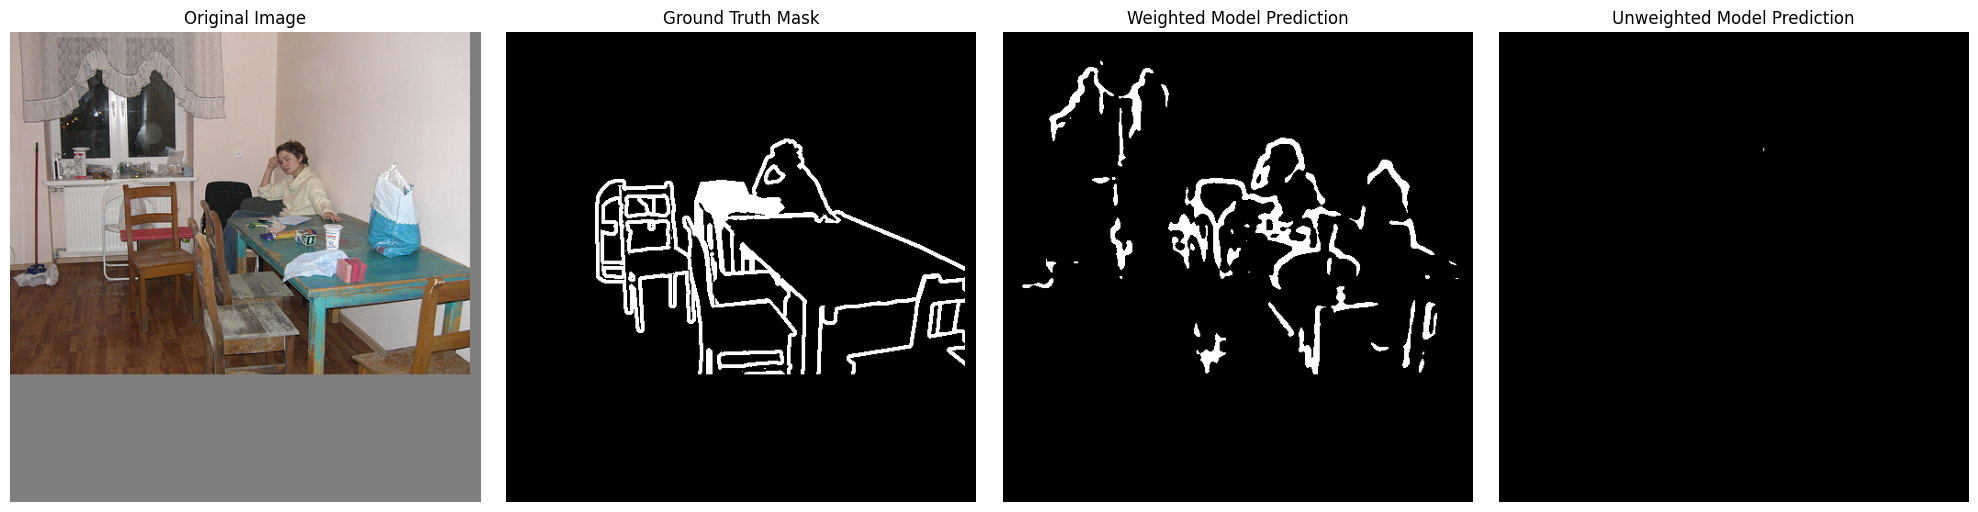

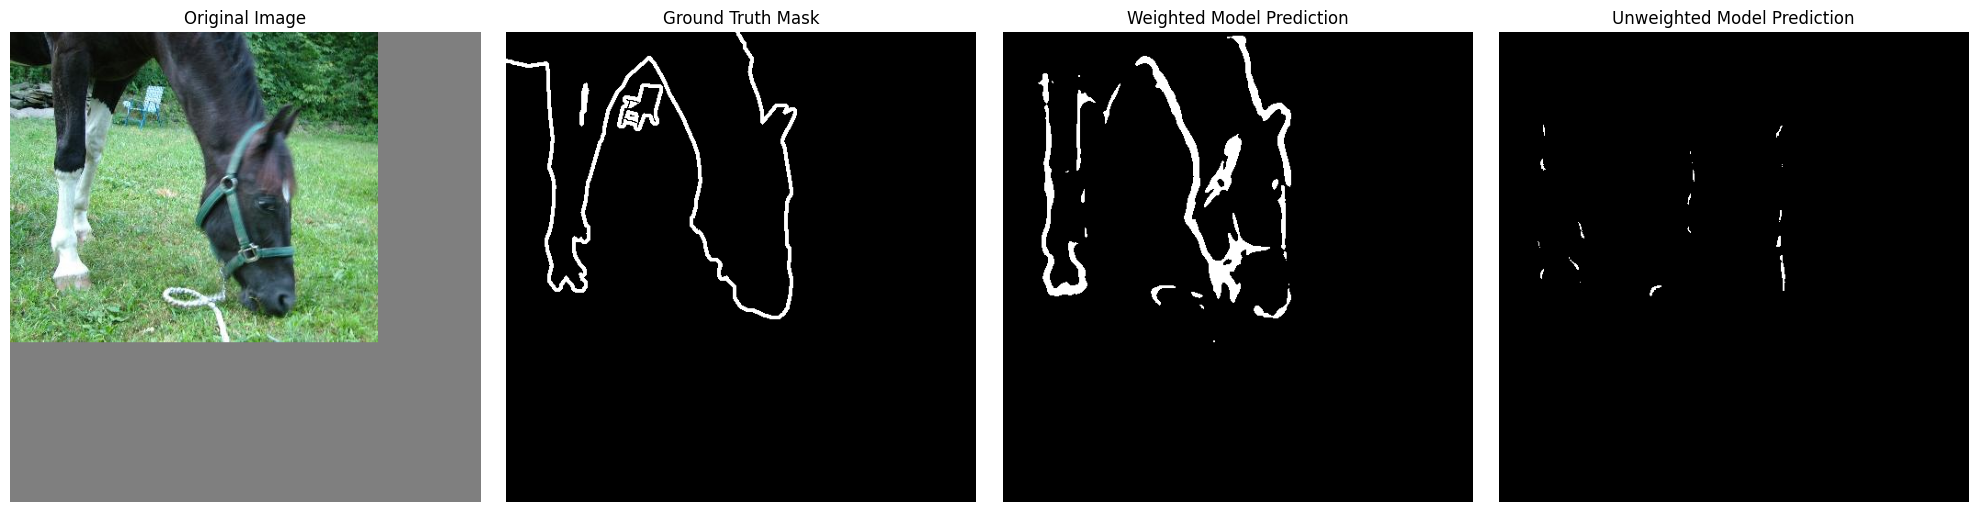

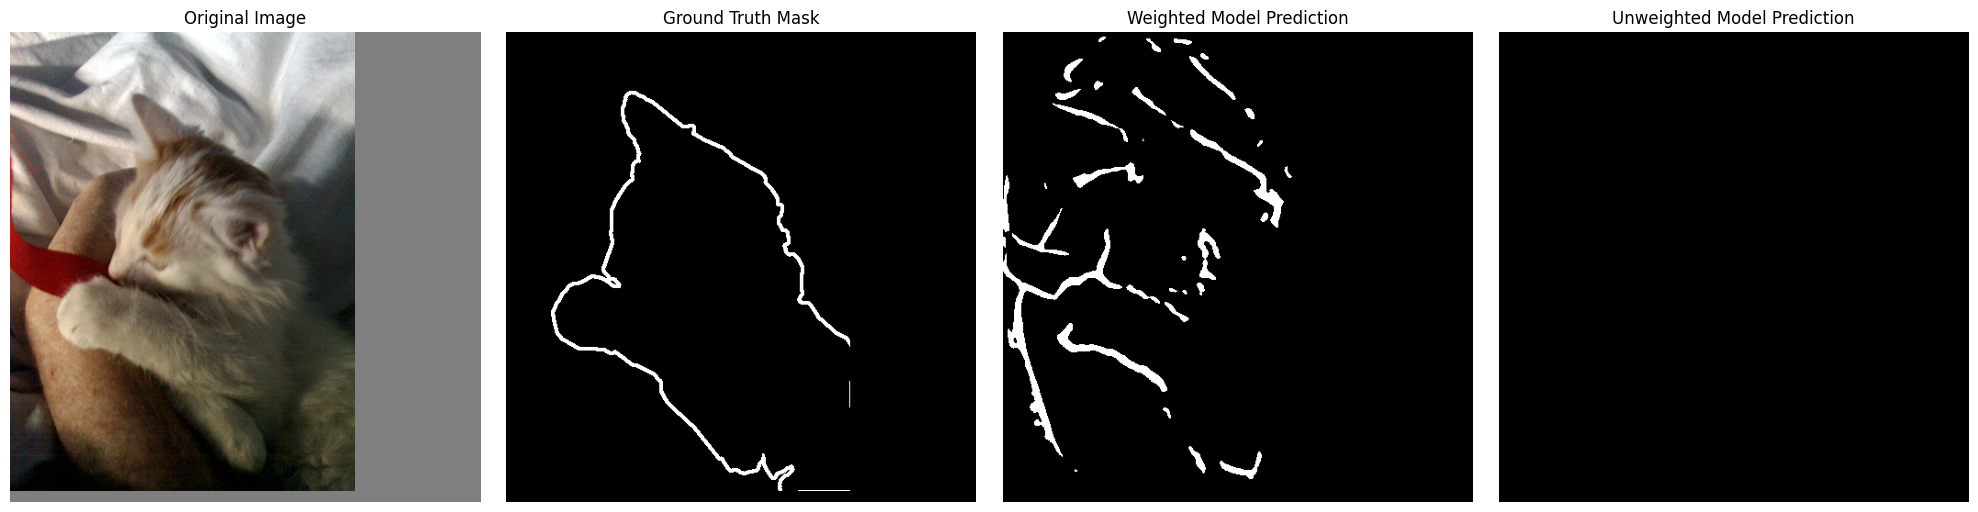

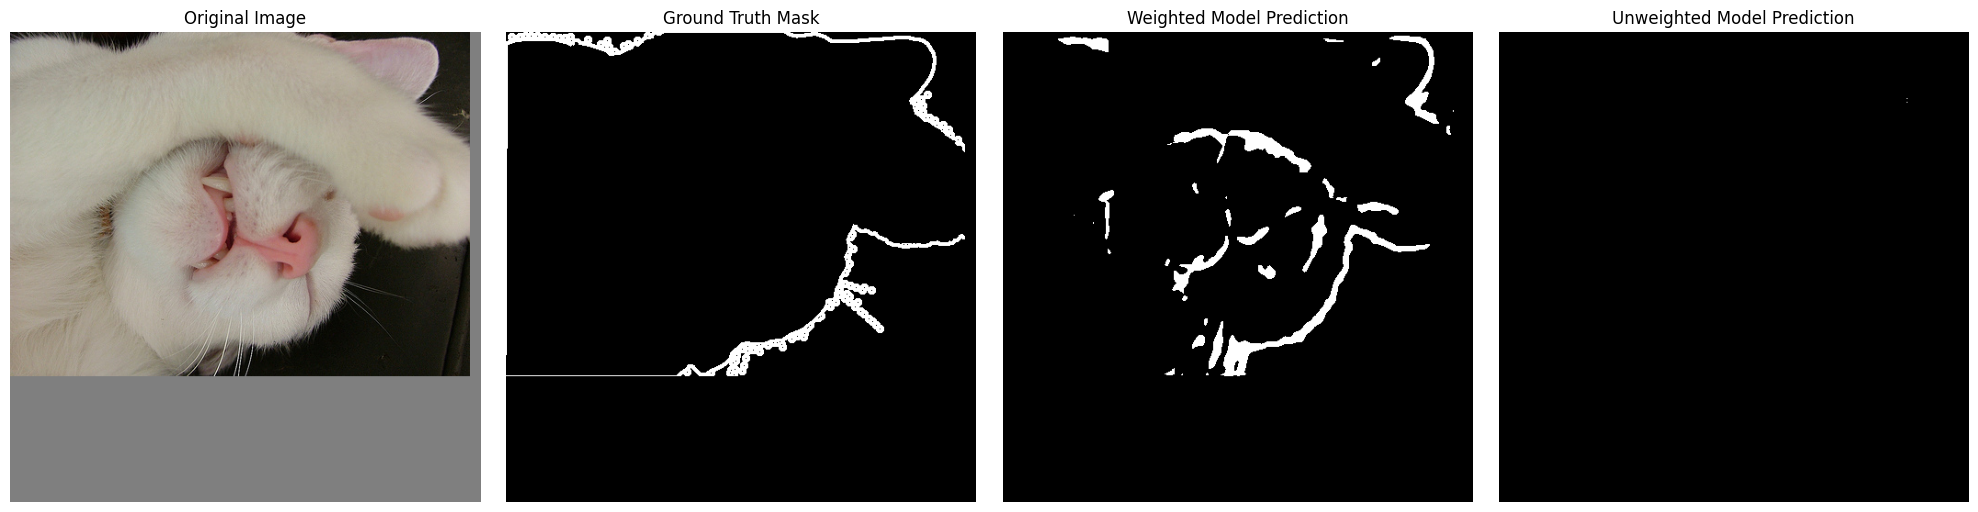

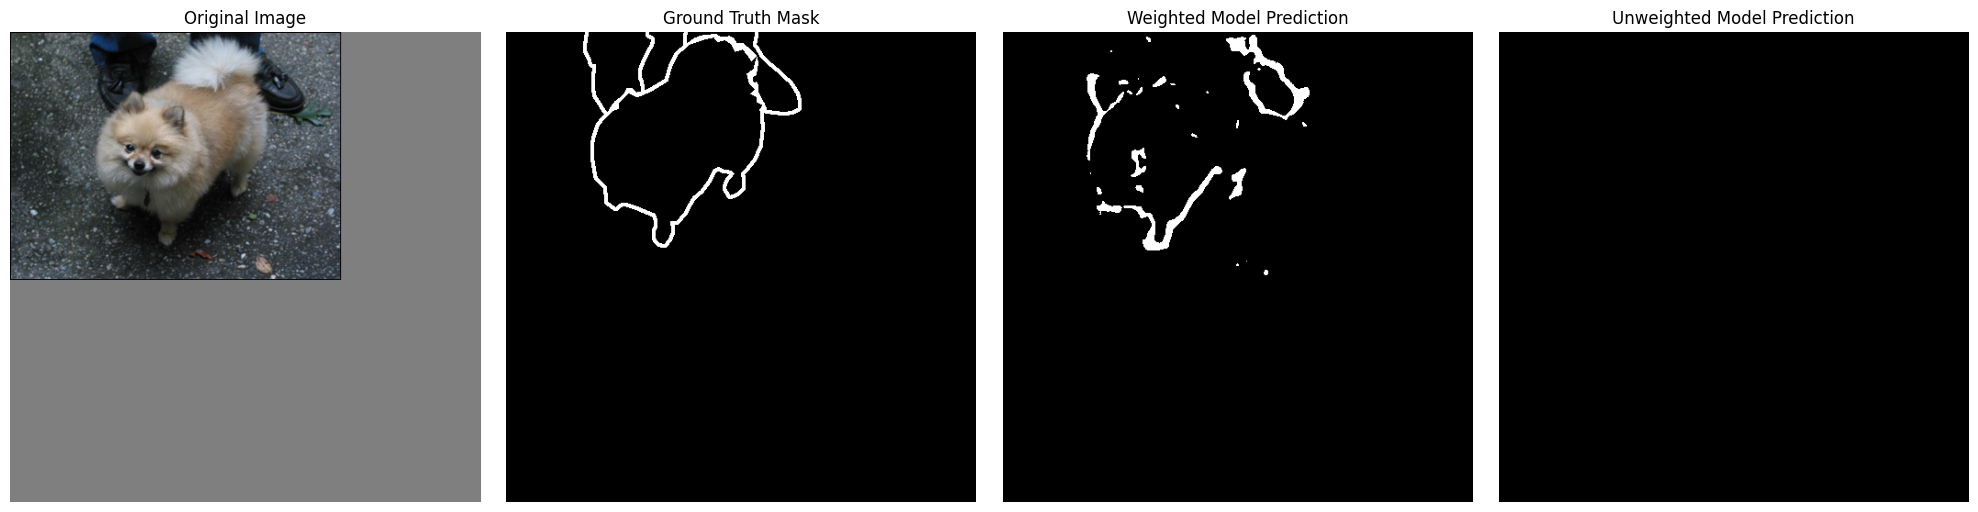

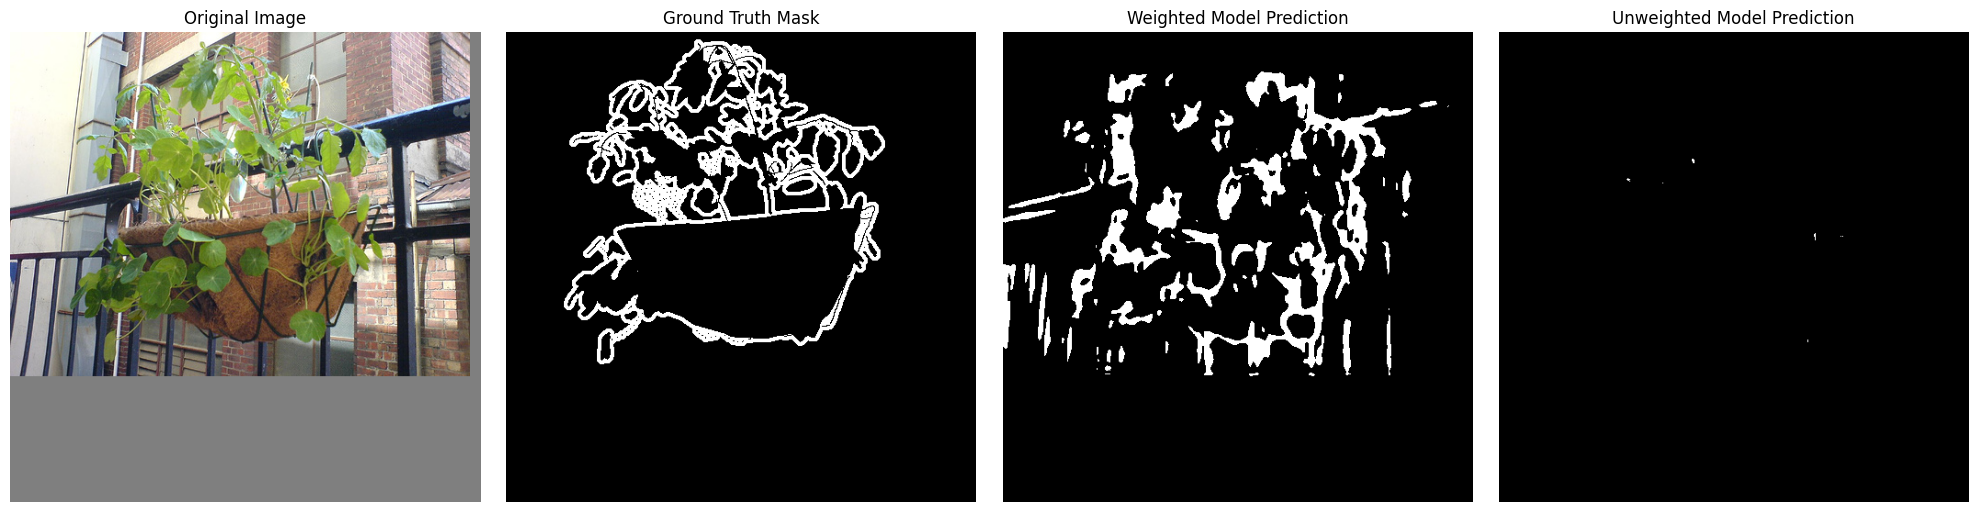

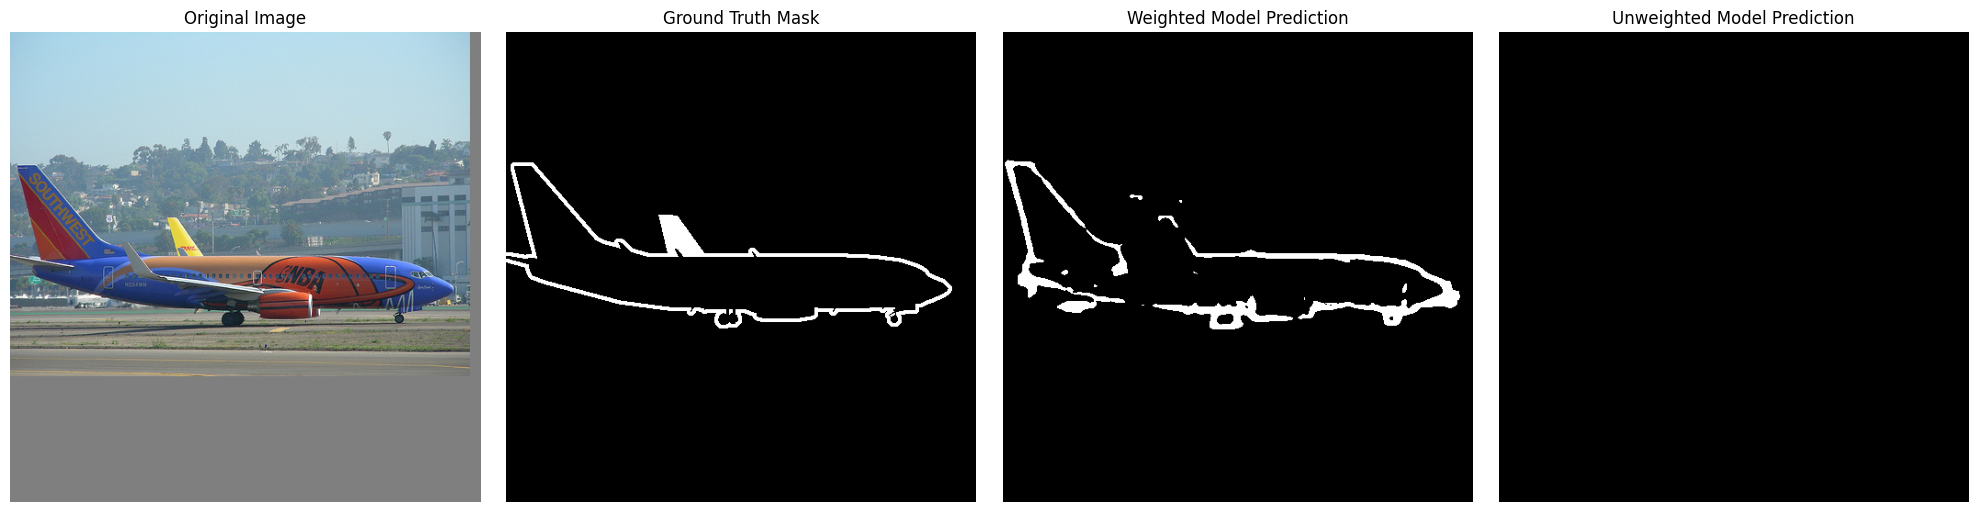

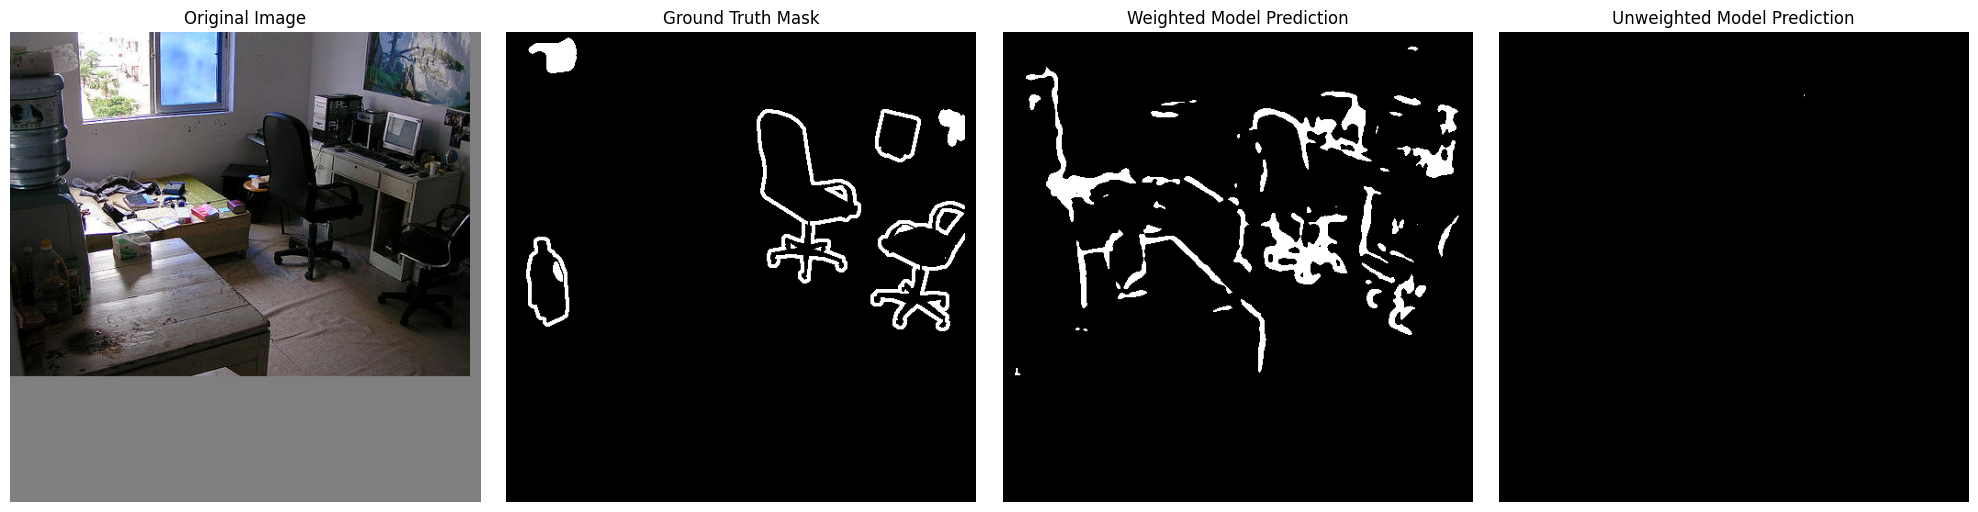

In [47]:
import matplotlib.pyplot as plt

# Initialize models
weighted_model = UNet()
unweighted_model = UNet()

# Load the saved weights
weighted_model_path = os.path.join(save_dir, "best_unet_model.pth")
unweighted_model_path = os.path.join(save_dir, "unweighted_bce_unet_model.pth")

weighted_model.load_state_dict(torch.load(weighted_model_path, map_location=device, weights_only=True))
unweighted_model.load_state_dict(torch.load(unweighted_model_path, map_location=device, weights_only=True))

# Initialization for evaluation
weighted_model.to(device)
unweighted_model.to(device)

weighted_model.eval()
unweighted_model.eval()

# Retrieve a batch of test images and masks
test_images, test_masks = next(iter(test_loader))
test_images = test_images.to(device)
test_masks = test_masks.to(device).float()

# Forward passes
with torch.no_grad():
    weighted_outputs = weighted_model(test_images)
    weighted_probs = torch.sigmoid(weighted_outputs)
    weighted_preds = (weighted_probs > 0.5).int()

    unweighted_outputs = unweighted_model(test_images)
    unweighted_probs = torch.sigmoid(unweighted_outputs)
    unweighted_preds = (unweighted_probs > 0.5).int()

# For each sample in batch
for sample_idx in range(test_images.shape[0]):

    # Transpose the image dimensions from (C,H,W) to (H,W,C)
    sample_image = test_images[sample_idx].cpu().numpy().transpose(1, 2, 0)
    sample_mask = test_masks[sample_idx].cpu().numpy().squeeze()
    sample_weighted_pred = weighted_preds[sample_idx].cpu().numpy().squeeze()
    sample_unweighted_pred = unweighted_preds[sample_idx].cpu().numpy().squeeze()

    # Inverse normalization
    sample_image = sample_image * 0.5 + 0.5  # Now back to [0,1]
    sample_image = sample_image.clip(0,1)

    # Plotting the results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(sample_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(sample_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(sample_weighted_pred, cmap='gray')
    axes[2].set_title("Weighted Model Prediction")
    axes[2].axis("off")

    axes[3].imshow(sample_unweighted_pred, cmap='gray')
    axes[3].set_title("Unweighted Model Prediction")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

# Ending comments

We can see that the predicted mask using a weighted BCE signifcantly outperforms the BCE loss without weighting. This gives an empirical validation of the results in the first conceptual section that discussses the issue of imbalanced data and how weighting helps us.

However, even with weighted BCE, the model performs best when the "background" is relatively "uniform", as seen in examples with the horse and airplane. To better capture "semantic edges" rather than edges corresponding to color gradients, the model would likely benefit from using the original segmentation mask and training to classify pixels into N classes, including void pixels, as in the original dataset. A postprocessing step could then classify void pixels as edges.